# Практическая работа №1. Временные ряды
### Цель: Изучение методов и технологий анализа временных рядов
### Выполнял: Самарин Н. А. КИ21-17/1Б
### Вариант 24(6) - WTI Price FOB

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy as sci
from scipy import stats
import itertools
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [14, 8]
matplotlib.rcParams['font.size'] = 12

In [2]:
def check_adfuller(data):
    test = sm.tsa.adfuller(data, autolag="AIC")
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']:
        print('ряд не стационарен')
    else:
        print('ряд стационарен')

def Foster_Stuart(data, p_level=0.95):
    a_level = 1 - p_level
    X = np.array(data)
    n = len(X)
    u = l = list()
    Xtemp = np.array(X[0])
    for i in range(1, n):
        Xmax = np.max(Xtemp)
        Xmin = np.min(Xtemp)
        u = np.append(u, 1 if X[i] > Xmax else 0)
        l = np.append(l, 1 if X[i] < Xmin else 0)
        Xtemp = np.append(Xtemp, X[i])
    d = np.int64(np.sum(u - l))
    s = np.int64(np.sum(u + l))
    mean_s = 2*np.sum([1/i for i in range(2, n+1)])
    std_d = sqrt(mean_s)
    std_s = sqrt(mean_s - 4*np.sum([1/i**2 for i in range(2, n+1)]))
    t_d = (d - 0)/std_d
    t_s = (s - mean_s)/std_s
    df = n
    t_table = sci.stats.t.ppf((1 + p_level)/2 , df)
    conclusion_d = "False" if t_d <= t_table else "True"
    conclusion_s = "False" if t_s <= t_table else "True"
    return "Тренд в среднем: " + conclusion_s + " , Тренд в дисперсии: " + conclusion_d

def show_plot(data):

    plt.plot(data, label = 'Оригинальный график', color = 'steelblue')
    plt.plot(data.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')
    plt.plot(data.rolling(window = 12).std(), label = 'Скользящее стандартное отклонение за 12 месяцев', color = 'green')
    plt.legend(title = '', loc = 'upper left')
    plt.show()

def show_prediction_plot(train, test, prediction, offset=0):
    plt.plot(train[offset:], color = "black", label = 'Тренировочная выборка')
    plt.plot(test, color = "red", label = 'Тестовая выборка')
    plt.plot(prediction, color="green", label='Предсказание')
    plt.legend(title = '', loc = 'upper left')
    plt.grid()
    plt.show()

def pqd_search(train, p_start, p_end, d_start, d_end, q_start, q_end):
    p = range(p_start,p_end)
    q = range(q_start,q_end)
    d = range(d_start, d_end)
    pdq = list(itertools.product(p, d, q))
    best_pdq = (0,0,0)
    best_aic = np.inf
    for params in pdq:
        try:
            model = SARIMAX(train, order=params)
            result = model.fit()
            if result.aic < best_aic:
                best_pdq = params
                best_aic = result.aic
        except:
            continue
    print("pdq - ", best_pdq)
    return best_pdq

def predict(train, model_type, lmbda, diff=0):
    p_start, p_end, d_start, d_end, q_start, q_end = 0, 1, 0, 1, 0, 1
    if model_type == "AR":
        p_start, p_end = 1, 10
    elif model_type == "MA":
        q_start, q_end = 1, 10
    elif model_type == "ARMA":
        p_start, p_end = 1, 10
        q_start, q_end = 1, 10
    elif model_type == "ARIMA":
        p_start, p_end = 1, 10
        q_start, q_end = 1, 10
        d_start, d_end = 1, 5
    if model_type != "ARMA" and diff > 0:
        d_start, d_end = 1, diff + 1

    model = SARIMAX(train.boxcox, order = pqd_search(train.boxcox, p_start, p_end, d_start, d_end, q_start, q_end)[0])
    fit_model = model.fit()
    print(fit_model.summary())
    aic = fit_model.aic
    predictions = fit_model.predict(start=test.index.min(), end=test.index.max())
    predictions = inv_boxcox(predictions, lmbda)

    return predictions, aic

In [3]:
cols = ["date", "price"]

data =  pd.read_csv("WTI Price FOB.csv", header=0, names = cols, parse_dates=["date"])
data.set_index('date', inplace=True)
data

C:\Users\yormu\AppData\Local\Temp\ipykernel_22564\1164866257.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data =  pd.read_csv("WTI Price FOB.csv", header=0, names = cols, parse_dates=["date"])


,price
date,
1986-01-01,22.93
1986-02-01,15.46
1986-03-01,12.61
1986-04-01,12.84
1986-05-01,15.38
...,...
2020-11-01,40.94
2020-12-01,47.02
2021-01-01,52.00


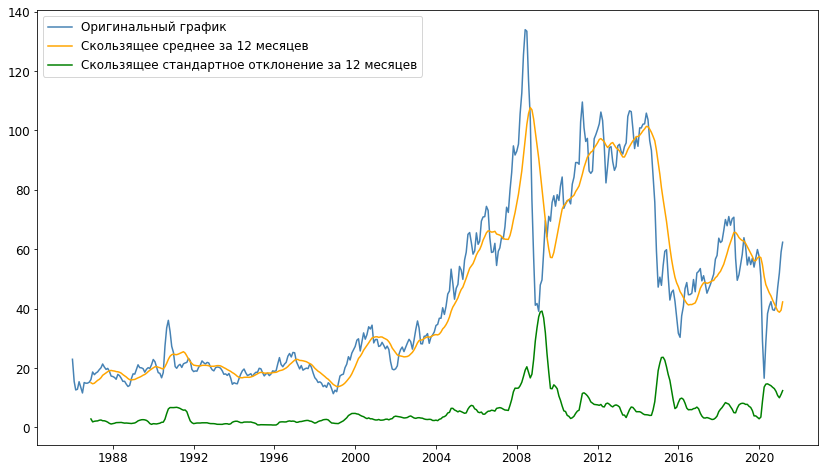

In [4]:
show_plot(data)

In [5]:
check_adfuller(data)

adf:  -2.5051168067794696
p-value:  0.1142343091462007
Critical values:  {'1%': -3.445978550826048, '5%': -2.8684297456394874, '10%': -2.570440005247093}
ряд не стационарен


Проверим наличие тренда тестом Фостера-Стьюарта и тестом Мана-Кендала

In [6]:
import pymannkendall as mk
print(Foster_Stuart(data.price))
mk.original_test(data.price)

Тренд в среднем: True , Тренд в дисперсии: True


Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=17.493298971411257, Tau=0.5693926254579678, s=50820.0, var_s=8439346.0, slope=0.1322801302931596, intercept=4.218892508143327)

Тренд есть, возрастающий

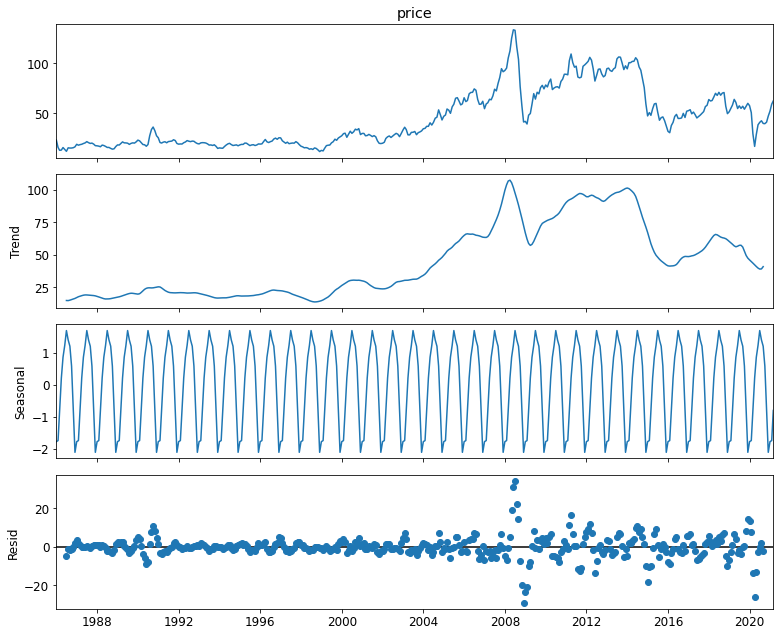

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decompose = seasonal_decompose(data.price)
decompose.plot()
plt.show()

Есть сезонность, значения возрастают ближе к середине каждого года

## Преобразование ряда

Приведём исходный ряд к стационарному используя преобразование Бокса-Кокса и дифференцирование.

adf:  -1.7539517258079098
p-value:  0.40355092894777767
Critical values:  {'1%': -3.4460914174990296, '5%': -2.868479374038333, '10%': -2.570466459559076}
ряд не стационарен


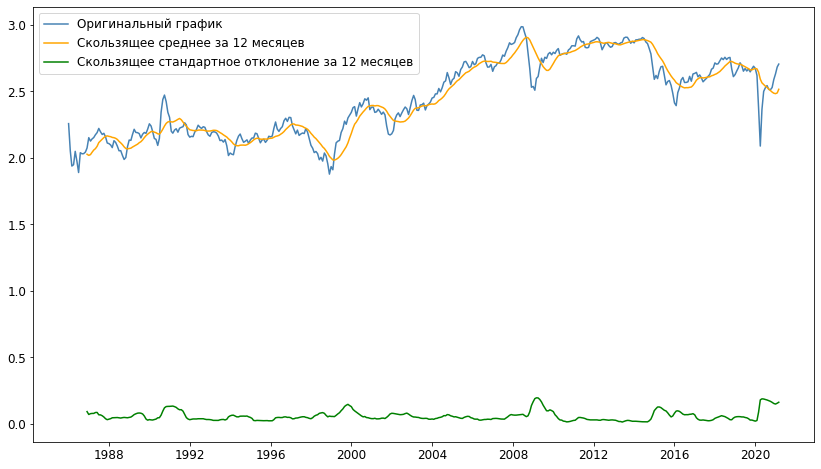

In [8]:
data['boxcox'], lmbda = stats.boxcox(data.price)
check_adfuller(data.boxcox)
matplotlib.rcParams['figure.figsize'] = [14, 8]
show_plot(data.boxcox)

adf:  -11.31847397431342
p-value:  1.1903065858526486e-20
Critical values:  {'1%': -3.4460914174990296, '5%': -2.868479374038333, '10%': -2.570466459559076}
ряд стационарен


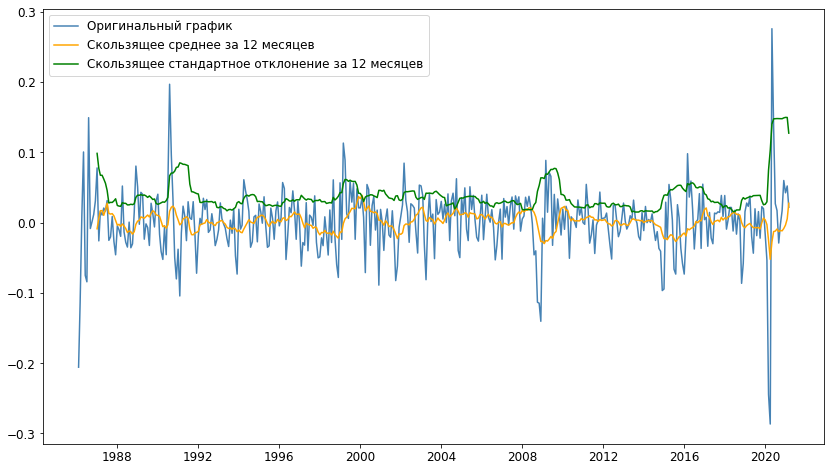

(array([  2.,   1.,   1.,  22., 135., 227.,  29.,   3.,   1.,   1.]),
 array([-0.28654184, -0.23030118, -0.17406052, -0.11781985, -0.06157919,
        -0.00533852,  0.05090214,  0.1071428 ,  0.16338347,  0.21962413,
         0.2758648 ]),
 <BarContainer object of 10 artists>)

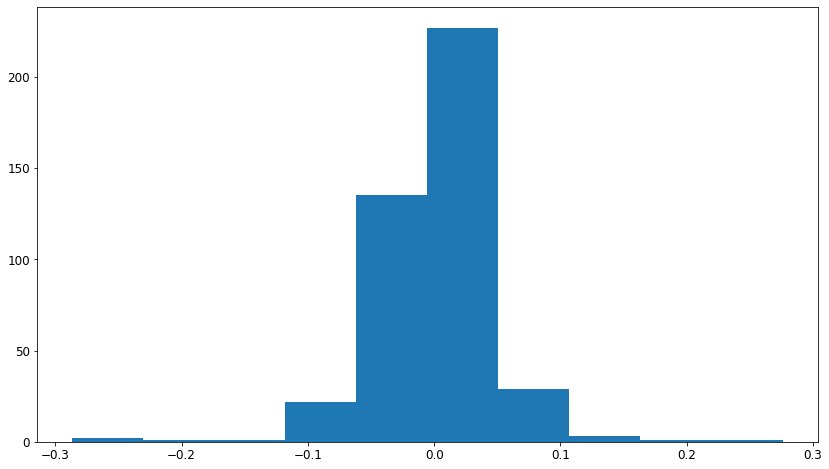

In [9]:
boxcox_diff = data.boxcox - data.boxcox.shift(1)
check_adfuller(boxcox_diff[1:])
show_plot(boxcox_diff[1:])
plt.hist(boxcox_diff[1:])

Ряд стационарен, значения подчиняются нормальному распределению. Ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка. Следовательно, параметр d = 1.

Определим параметры p и q, построив коррелограммы.

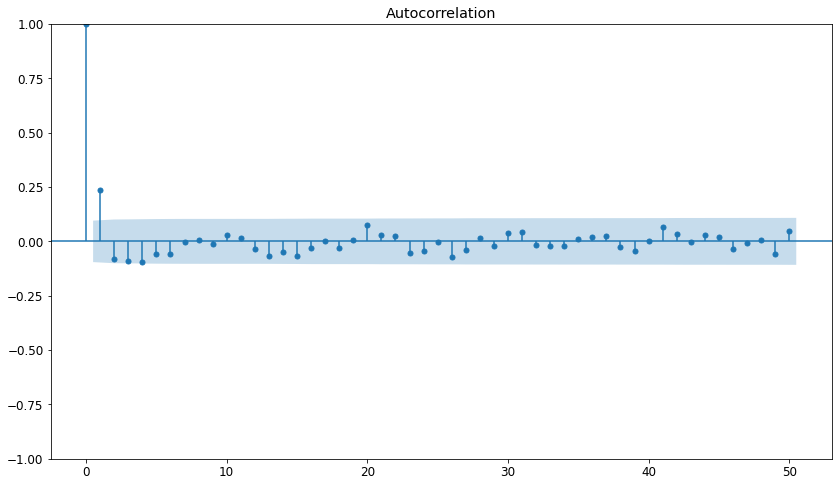

In [10]:
plot_acf(boxcox_diff[1:], lags=50)
plt.show()

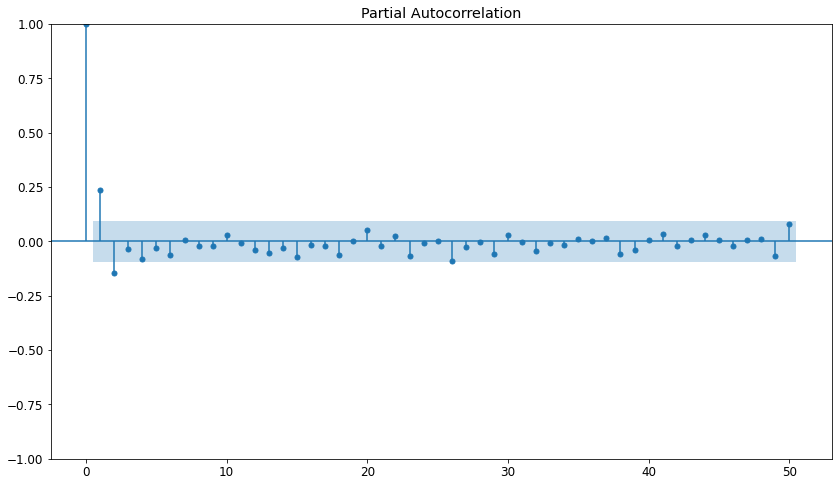

In [11]:
plot_pacf(boxcox_diff[1:], lags=50)
plt.show()

После изучения коррелограммы PACF можно сделать вывод, что p = 2, т.к. на ней 2 лага сильно больше от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.

## Модели

In [12]:
rmse_long = {}
aic_long = {}
rmse_short = {}
aic_short = {}

### Долгосрочные прогнозы (45 месяцев)

In [13]:
train_size = 378
train = data.iloc[:train_size]
test = data.iloc[train_size:]
print(f'В тренировочной выборке {train_size}. В тестовой {test.shape[0]}')

В тренировочной выборке 378. В тестовой 45


#### Модель авторегрессии AR(p).

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

pdq -  (1, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  378
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 682.032
Date:                Wed, 04 Oct 2023   AIC                          -1360.063
Time:                        12:12:33   BIC                          -1352.199
Sample:                    01-01-1986   HQIC                         -1356.942
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2662      0.038      7.043      0.000       0.192       0.340
sigma2         0.0016   7.25e-05     21.652      0.000       0.001       0.002
Ljung-Box (L1) (Q):                

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


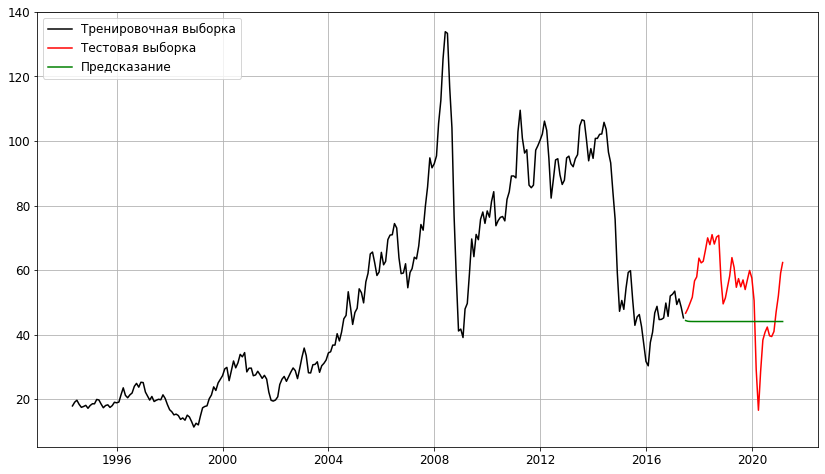

In [14]:
prediction, aic = predict(train, "AR", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 100)

In [15]:
rmse_long["prediction_ar"] = mean_squared_error(test.price, prediction, squared=False)
aic_long["prediction_ar"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1360.0631917613746
RMSE = 15.243558647876435


In [16]:
#

In [17]:
data["prediction_ar_long"] = prediction

#### Модель скользящего среднего MA(q).

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

pdq -  (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  378
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 682.437
Date:                Wed, 04 Oct 2023   AIC                          -1360.875
Time:                        12:12:37   BIC                          -1353.010
Sample:                    01-01-1986   HQIC                         -1357.753
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2715      0.041      6.623      0.000       0.191       0.352
sigma2         0.0016   7.46e-05     21.014      0.000       0.001       0.002
Ljung-Box (L1) (Q):                

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


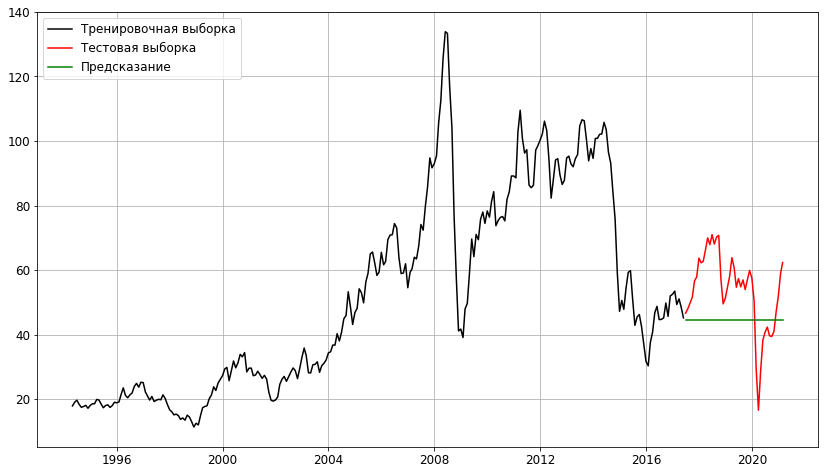

In [18]:
prediction, aic = predict(train, "MA", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 100)

In [19]:
rmse_long["prediction_ma"] = mean_squared_error(test.price, prediction, squared=False)
aic_long["prediction_ma"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1360.87490716302
RMSE = 14.935055092913466


In [20]:
#

In [21]:
data["prediction_ma_long"] = prediction

#### Модель авторегрессии – скользящего среднего ARMA(p, q)

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency in

pdq -  (1, 0, 1)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  378
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 680.147
Date:                Wed, 04 Oct 2023   AIC                          -1354.293
Time:                        12:14:43   BIC                          -1342.488
Sample:                    01-01-1986   HQIC                         -1349.608
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.001    944.790      0.000       0.998       1.002
ma.L1          0.2713      0.042      6.504      0.000       0.190       0.353
sigma2         0.0016   7.46e-05   

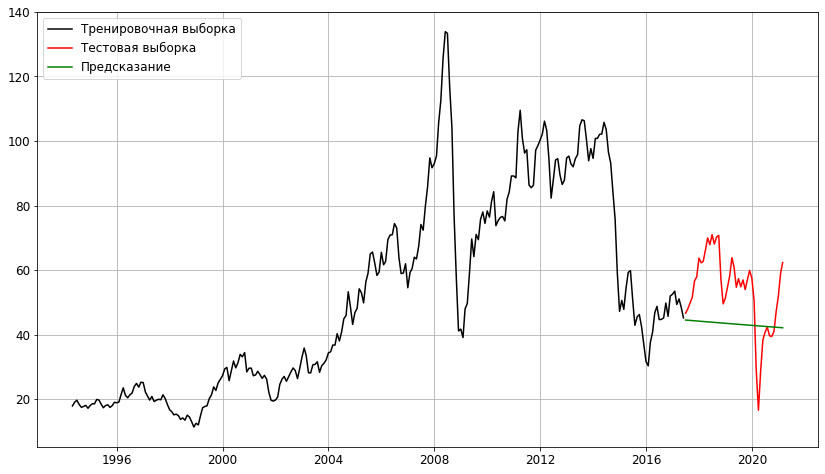

In [22]:
prediction, aic = predict(train, "ARMA", lmbda)
show_prediction_plot(train.price, test.price, prediction, 100)

In [23]:
rmse_long["prediction_arma"] = mean_squared_error(test.price, prediction, squared=False)
aic_long["prediction_arma"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1354.2930485286126
RMSE = 15.505482251629765


In [24]:
#

In [25]:
data["prediction_arma_long"] = prediction

#### Модель авторегрессии – проинтегрированного скользящего среднего(p, d, q)

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. 

pdq -  (2, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  378
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 685.475
Date:                Wed, 04 Oct 2023   AIC                          -1362.950
Time:                        12:15:47   BIC                          -1347.221
Sample:                    01-01-1986   HQIC                         -1356.707
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1873      0.061     19.484      0.000       1.068       1.307
ar.L2         -0.2962      0.038     -7.892      0.000      -0.370      -0.223
ma.L1         -0.9247      0.055   

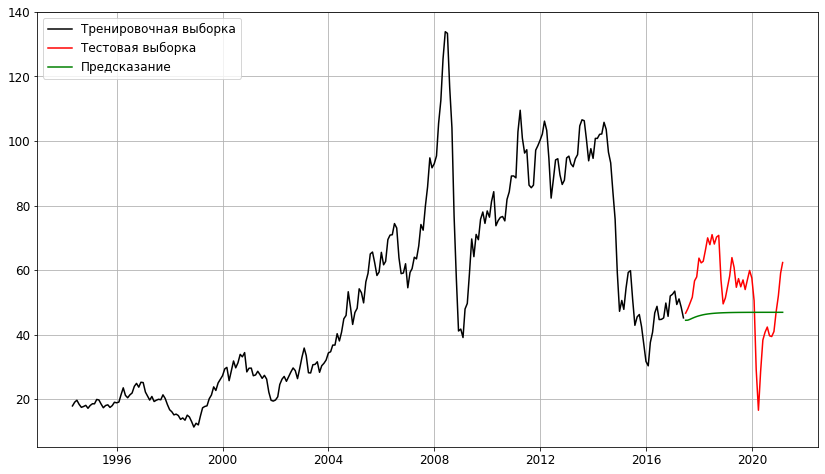

In [26]:
prediction, aic = predict(train, "ARIMA", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 100)

In [27]:
rmse_long["prediction_arima"] = mean_squared_error(test.price, prediction, squared=False)
aic_long["prediction_arima"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1362.9500594475307
RMSE = 13.889118290493975


In [28]:
#

In [29]:
data["prediction_arima_long"] = prediction

### Краткосрочные прогнозы (8 месяцев)

In [30]:
train_size = 415
train = data.iloc[:train_size]
test = data.iloc[train_size:]
print(f'В тренировочной выборке {train_size}. В тестовой {test.shape[0]}')

В тренировочной выборке 415. В тестовой 8


#### Модель авторегрессии AR(p).

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

pdq -  (2, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  415
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 698.762
Date:                Wed, 04 Oct 2023   AIC                          -1391.524
Time:                        12:15:49   BIC                          -1379.446
Sample:                    01-01-1986   HQIC                         -1386.747
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2758      0.032      8.704      0.000       0.214       0.338
ar.L2         -0.1544      0.048     -3.211      0.001      -0.249      -0.060
sigma2         0.0020   7.36e-05   

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


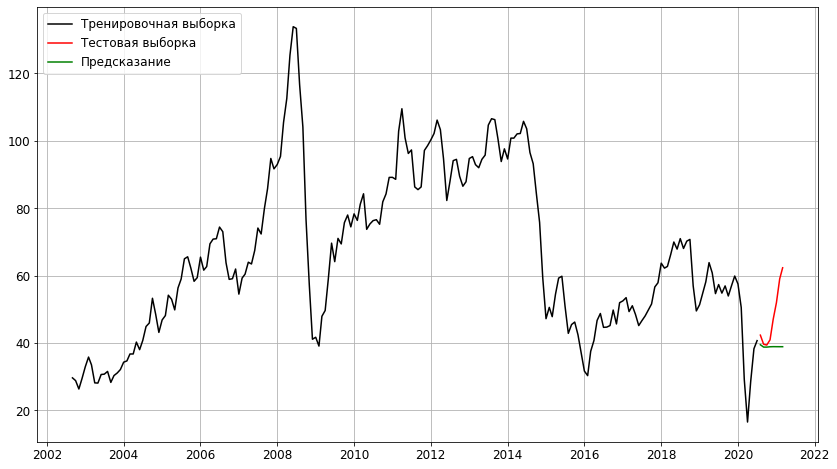

In [31]:
prediction, aic = predict(train, "AR", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 200)

In [32]:
rmse_short["prediction_ar"] = mean_squared_error(test.price, prediction, squared=False)
aic_short["prediction_ar"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1391.5236806141136
RMSE = 12.271004030890726


In [33]:
#

In [34]:
data["prediction_ar_short"] = prediction

#### Модель скользящего среднего MA(q).

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency

pdq -  (0, 1, 4)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  415
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 700.829
Date:                Wed, 04 Oct 2023   AIC                          -1391.658
Time:                        12:15:53   BIC                          -1371.529
Sample:                    01-01-1986   HQIC                         -1383.697
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2595      0.032      8.215      0.000       0.198       0.321
ma.L2         -0.1032      0.038     -2.697      0.007      -0.178      -0.028
ma.L3         -0.1221      0.059   

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


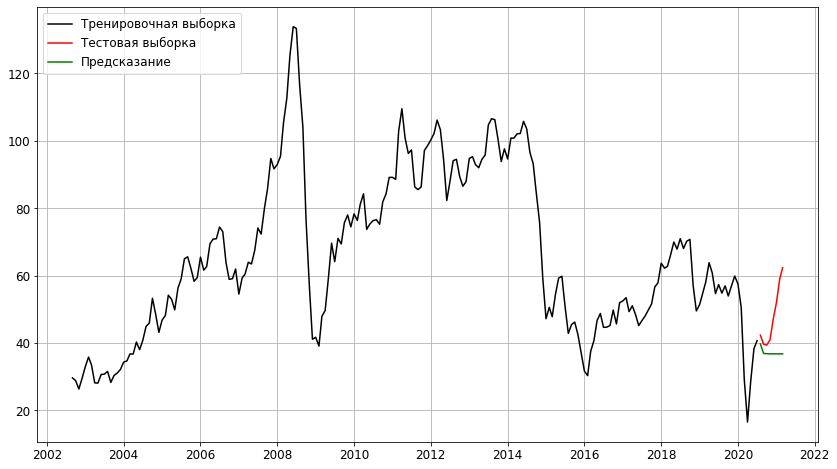

In [35]:
prediction, aic = predict(train, "MA", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 200)

In [36]:
rmse_short["prediction_ma"] = mean_squared_error(test.price, prediction, squared=False)
aic_short["prediction_ma"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1391.6580010050818
RMSE = 13.79038741599067


In [37]:
#

In [38]:
data["prediction_ma_short"] = prediction

#### Модель авторегрессии – скользящего среднего ARMA(p, q)

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency in

pdq -  (1, 0, 4)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  415
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 698.569
Date:                Wed, 04 Oct 2023   AIC                          -1385.137
Time:                        12:17:23   BIC                          -1360.968
Sample:                    01-01-1986   HQIC                         -1375.580
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.001   1042.109      0.000       0.998       1.002
ma.L1          0.2595      0.033      7.942      0.000       0.195       0.324
ma.L2         -0.1033      0.039   

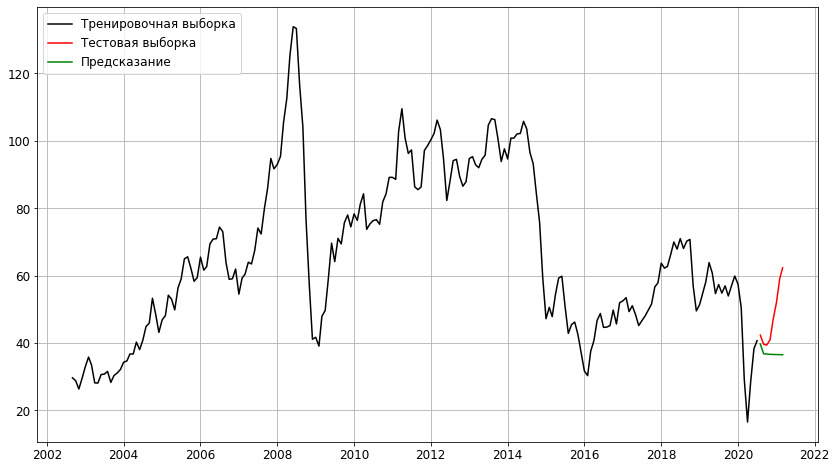

In [39]:
prediction, aic = predict(train, "ARMA", lmbda)
show_prediction_plot(train.price, test.price, prediction, 200)

In [40]:
rmse_short["prediction_arma"] = mean_squared_error(test.price, prediction, squared=False)
aic_short["prediction_arma"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1385.137351931695
RMSE = 13.962128893590261


In [41]:
#

In [42]:
data["prediction_arma_short"] = prediction

#### Модель авторегрессии – проинтегрированного скользящего среднего(p, d, q)

C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Projects\SFU\TVO\pr1\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. 

pdq -  (1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                 boxcox   No. Observations:                  415
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 702.195
Date:                Wed, 04 Oct 2023   AIC                          -1396.389
Time:                        12:18:29   BIC                          -1380.286
Sample:                    01-01-1986   HQIC                         -1390.021
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8345      0.063     13.166      0.000       0.710       0.959
ma.L1         -0.5830      0.080     -7.330      0.000      -0.739      -0.427
ma.L2         -0.3198      0.044   

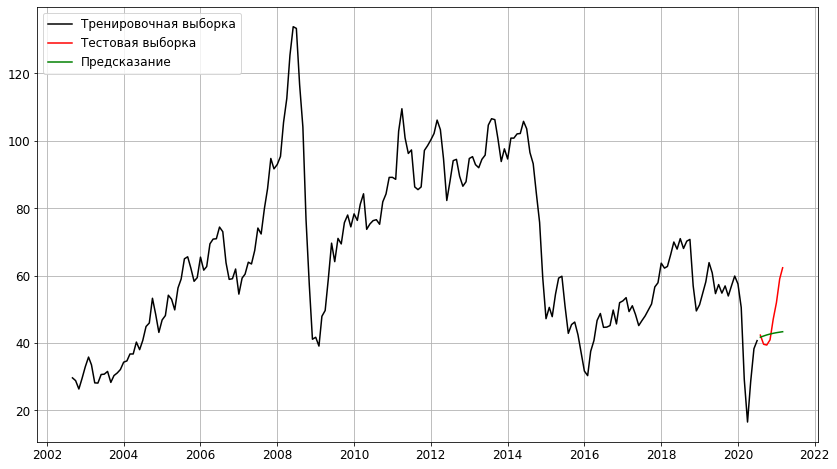

In [43]:
prediction, aic = predict(train, "ARIMA", lmbda, 1)
show_prediction_plot(train.price, test.price, prediction, 200)

In [44]:
rmse_short["prediction_arima"] = mean_squared_error(test.price, prediction, squared=False)
aic_short["prediction_arima"] = aic
print(f'AIC = {aic}')
print(f'RMSE = {mean_squared_error(test.price, prediction, squared=False)}')

AIC = -1396.3892720132567
RMSE = 9.524029847104677


In [45]:
#

In [46]:
data["prediction_arima_short"] = prediction

## Сравнение моделей

Минимальное значение AIC: -1362.9500594475307
Минимальное значение RMSE: 13.889118290493975
Модели с минимальным значением AIC: ['prediction_arima']
Модели с минимальным значением RMSE: ['prediction_arima']


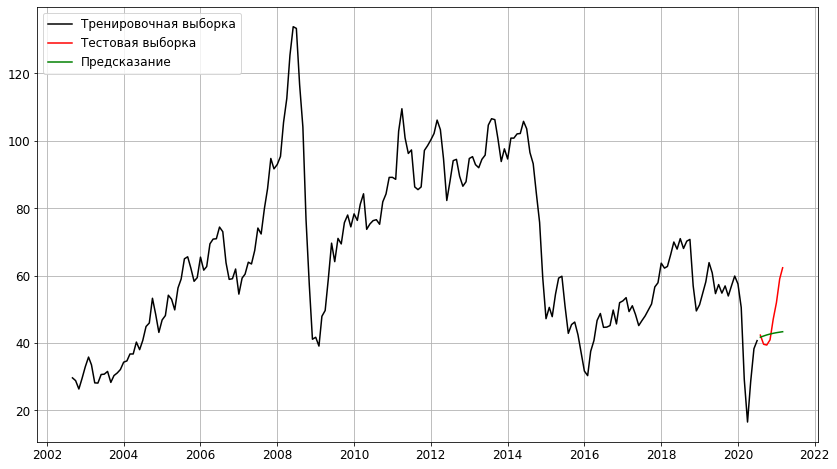

In [47]:
min_aic_long = min(aic_long.values())
min_rmse_long = min(rmse_long.values())

min_rmse_models = [key for key, value in rmse_long.items() if value == min_rmse_long]
min_aic_models = [key for key, value in aic_long.items() if value == min_aic_long]

print("Минимальное значение AIC:", min_aic_long)
print("Минимальное значение RMSE:", min_rmse_long)
print("Модели с минимальным значением AIC:", min_aic_models)
print("Модели с минимальным значением RMSE:", min_rmse_models)
show_prediction_plot(train.price, test.price, prediction, 200)

Минимальное значение AIC: -1396.3892720132567
Минимальное значение RMSE: 9.524029847104677
Модели с минимальным значением AIC: ['prediction_arima']
Модели с минимальным значением RMSE: ['prediction_arima']


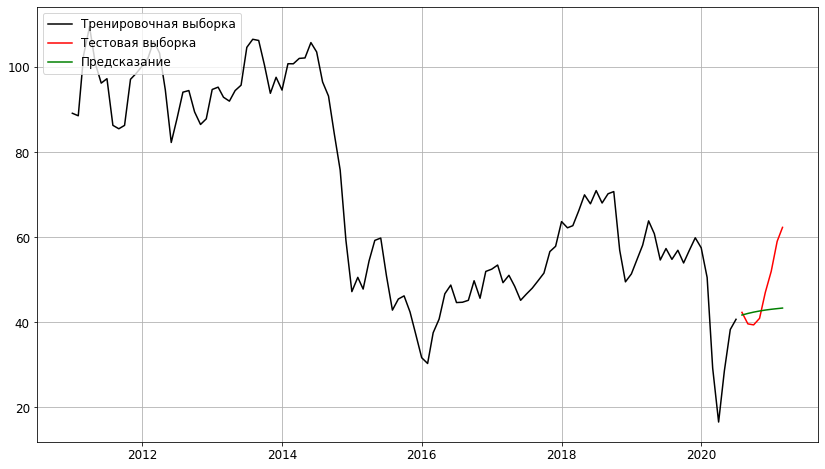

In [48]:
min_aic_short = min(aic_short.values())
min_rmse_short = min(rmse_short.values())

min_rmse_models = [key for key, value in rmse_short.items() if value == min_rmse_short]
min_aic_models = [key for key, value in aic_short.items() if value == min_aic_short]

print("Минимальное значение AIC:", min_aic_short)
print("Минимальное значение RMSE:", min_rmse_short)
print("Модели с минимальным значением AIC:", min_aic_models)
print("Модели с минимальным значением RMSE:", min_rmse_models)
show_prediction_plot(train.price, test.price, prediction, 300)

## Вывод

И для краткосрочных и для долгосрочных прогнозов для данного временного ряда лучшей является модель ARIMA